# Sentiment analysis

This notebook describes the sentiment analysis steps that were undertaken. In the first part, we extract the sentiment of each quotes. In the second, we provide some descriptive statistics of the final dataset.

## Setup

In [3]:
# Built-in
import os
from IPython.display import display

# Third parties
import numpy as np
import pandas as pd
import nltk
from nltk import tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time

from textblob import TextBlob  # pip install textblob
from flair.models import TextClassifier  # pip install flair
from flair.data import Sentence
import pandas as pd

generate_df = False

In [4]:
# Initialization needed for some modules

# tqdm for pandas
tqdm.pandas()

# NLTK configuration
nltk.download('vader_lexicon')
nltk.download('stopwords')
sia = SentimentIntensityAnalyzer()

# TokenSpace initialization
tokenSpace = tokenize.WhitespaceTokenizer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/AndreasPlesner/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/AndreasPlesner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Configuration
DATA_PATH = "data"
PKL_PATH = os.path.join(DATA_PATH, "pkl")
CSV_PATH = os.path.join(DATA_PATH, "csv")
RESOURCES_PATH = os.path.join(DATA_PATH, "resources")

In [6]:
# Utils functions

def get_sentiment(row: pd.Series) -> pd.Series:
    """
    Compute the sentiment score of a given row
    """   
    
    row['NLTK_score'] = sia.polarity_scores(row['quotation'])
    return row

def counter(text, columnText, quantity, label):
    allWords = ' '.join([text for text in text[columnText].astype('str')])
    tokenPhrase = tokenSpace.tokenize(allWords)
    frequency = nltk.FreqDist(tokenPhrase) 
    dfFrequency = pd.DataFrame({"Word": list(frequency.keys()), "Frequency": list(frequency.values())}) 
    
    dfFrequency = dfFrequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(15,3))
    ax = sns.barplot(data = dfFrequency, x = "Word", y = "Frequency", palette="deep")
    ax.set(ylabel = "Count")
    plt.xticks(rotation='horizontal')
    plt.title(f"Most common words for {label}")
    plt.show()

def get_day(date):
    """
    Extract the day date from a datetime object
    """

    date = str(date)
    date = date.split(" ")
    date.pop(-1)
    date = "".join(date)
    
    return pd.to_datetime(date)

## 1. Compute sentiment score

Since we have all our extracted mentions dataset, we will simply load each year and create a final aggregated dataframe, since it is not too big (around 100k quotes).

In [7]:
if generate_df:
    df_lst = []

    mentions = [os.path.join(CSV_PATH, f"20{i:02d}_mentions.csv") for i in range(15, 21)]  

    for mention in mentions:
        df_mention = pd.read_csv(mention)
        df_lst.append(df_mention)

    # Concatenate every year together
    df = pd.concat(df_lst) 

### TextBlob implementation

In [8]:
def score_sent_textblob(quote):
    txt = TextBlob(quote)
    return txt.sentiment[0]

In [9]:
if generate_df:
    df["textblob_score"] = df["quotation"].progress_apply(score_sent_textblob)

### Flair implementation

In [10]:
classifier = TextClassifier.load('en-sentiment')

def score_sent_flair(quote):
    txt = Sentence(quote)
    classifier.predict(txt)
    value = txt.labels[0].to_dict()['value'] 
    if value == 'POSITIVE':
        result = txt.to_dict()['labels'][0]['confidence']
    else:
        result = -(txt.to_dict()['labels'][0]['confidence'])
    return result

2021-12-13 16:33:38,169 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /var/folders/1v/6w4955p56_x7nlvd_dt6r9yh0000gn/T/tmpp_7alyjb


100%|██████████| 265512723/265512723 [02:05<00:00, 2121345.07B/s]

2021-12-13 16:35:43,622 copying /var/folders/1v/6w4955p56_x7nlvd_dt6r9yh0000gn/T/tmpp_7alyjb to cache at /Users/AndreasPlesner/.flair/models/sentiment-en-mix-distillbert_4.pt


2021-12-13 16:35:47,164 removing temp file /var/folders/1v/6w4955p56_x7nlvd_dt6r9yh0000gn/T/tmpp_7alyjb
2021-12-13 16:35:47,406 loading file /Users/AndreasPlesner/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 4.29kB/s]
Downloading: 100%|██████████| 226k/226k [00:00<00:00, 252kB/s]
Downloading: 100%|██████████| 455k/455k [00:01<00:00, 360kB/s]
Downloading: 100%|██████████| 483/483 [00:00<00:00, 125kB/s]


In [9]:
if generate_df:
    time1 = time.perf_counter()
    df["flair_score"] = df["quotation"].progress_apply(score_sent_flair)
    time2 = time.perf_counter()
    print('time :', time2-time1)

100%|█████████████████████████████████████████████████████████████████████████████████████| 105929/105929 [1:06:02<00:00, 26.73it/s]

time : 3962.9143627000003


In [13]:
if generate_df:
    df.head(1)

,Unnamed: 0,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,...,position,stateName,parties,NLTK score,neg,neu,pos,compound,textblob_score,flair_score
0,1356,2015-12-11-098688,the bill that republicans tried to place in th...,dianne feinstein,['Q230733'],2015-12-11 19:13:13,5.0,"[['Dianne Feinstein', '0.6281'], ['None', '0.3...",['http://thehill.com/policy/energy-environment...,E,...,Senator,CA,Democrat,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0,0.0,-0.999731


We see that flair is not adapted. The score is not the "degree sentiment" but only the confidence.

In [14]:
if generate_df:
    df.to_pickle(os.path.join(PKL_PATH, "final_subset_flaired.pkl"))

## 2. Sentiment analysis

We will now perform some preliminary analysis, having in mind that we want to analyze the evolution of the sentiment scores accross time. In the first section, we will present some basic descriptive statistics about the data we are working with.

In [11]:
# To avoid running the above cells, we load the dataframe directly
# either from csv or pickle

# For Mac users :
df = pd.read_pickle(os.path.join(PKL_PATH, "final_subset_flaired.pkl"))

### For windows users :
# from pickle5 import pickle
# with open("data/pkl/final_subset_flaired.pkl", "rb") as fh:
#     df = pickle.load(fh)

### a. Descriptive statistics

In this section, we simply explore the data we have to deal with. We look at it in an aggregated way, not separated by party.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105929 entries, 0 to 6361
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            105929 non-null  int64  
 1   quoteID               105929 non-null  object 
 2   quotation             105929 non-null  object 
 3   speaker               105929 non-null  object 
 4   qids                  105929 non-null  object 
 5   date                  105929 non-null  object 
 6   numOccurrences        105929 non-null  float64
 7   probas                105929 non-null  object 
 8   urls                  105929 non-null  object 
 9   phase                 105929 non-null  object 
 10  subset                105929 non-null  bool   
 11  id                    82439 non-null   object 
 12  givenName             105929 non-null  object 
 13  familyName            105929 non-null  object 
 14  unaccentedGivenName   105929 non-null  object 
 15  un

We see that we have many columns (32!). We decided to keep everything for now, as we might need something. We will scrap some information later on.

In [13]:
df.sample(2)

,Unnamed: 0,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,...,position,stateName,parties,NLTK score,neg,neu,pos,compound,textblob_score,flair_score
9177,72909,2016-09-13-031963,hillary clinton has been running a hate-filled...,donald trump,"['Q22686', 'Q27947481']",2016-09-13 21:01:50,2.0,"[['Donald Trump', '0.6688'], ['None', '0.1977'...","['http://www.people.com/people/article/0,,2102...",E,...,President,NaN,Republican,"{'neg': 0.38, 'neu': 0.576, 'pos': 0.045, 'com...",0.380,0.576,0.045,-0.9153,-0.184091,-0.965114
5490,43707,2015-02-15-038076,the senate democrats should be to blame.,john boehner,['Q11702'],2015-02-15 23:57:52,1.0,"[['John Boehner', '0.661'], ['None', '0.3248']...",['http://www.theepochtimes.com/n3/1251570-boeh...,E,...,Representative,OH,Republican,"{'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'comp...",0.286,0.714,0.000,-0.3400,0.000000,-0.991896


Here we see what a small sample of the data looks like.

In [14]:
print("Unique speakers count: ", len(df["speaker"].unique()))

Unique speakers count:  776


This count (776) unique speakers means that not every politician included in the congress biography list was quoted. We should also keep in mind that those are not truly "unique" speakers, since we currently have aliases for Donald Trump. In the future, we will have many more aliases for many of the speaker. Those aliases will be extracted using the `speaker_attributes` file.


In [15]:
trump_aliases = df[df["speaker"].str.contains("trump")]["speaker"].unique()
print("Number of current aliases for Trump: ", len(trump_aliases))
trump_aliases

Number of current aliases for Trump:  3


array(['donald trump', 'president trump', 'president donald trump'],
      dtype=object)

Next, we are interested about the sentiment scores.

In [17]:
df['flair_score'].describe()

count    105929.000000
mean         -0.414152
std           0.835092
min          -0.999999
25%          -0.997761
50%          -0.963052
75%           0.678737
max           0.999962
Name: flair_score, dtype: float64

For our analysis, we decided to only use the `compound` score, as it is the normalized final score of each separate score.
As we can see, most quotes are scored as "neutral". The median is perfectly at 0 and the mean is very similar. Below is the distribution illustrated:

Text(0, 0.5, 'count')

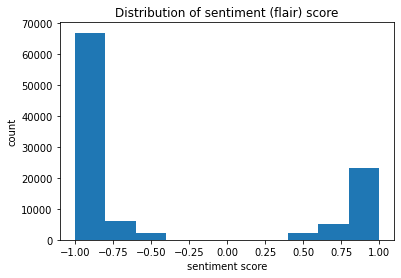

In [18]:
plt.hist(df["flair_score"])
plt.title("Distribution of sentiment (flair) score")
plt.xlabel("sentiment score")
plt.ylabel("count")

In [21]:
print('# of samples with |flair score|<0.5:', (abs(df['flair_score']) < 0.5).sum()) # weird

# of samples with |flair score|<0.5: 0


What about its evolution accross time?

In [22]:
df = df.reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])

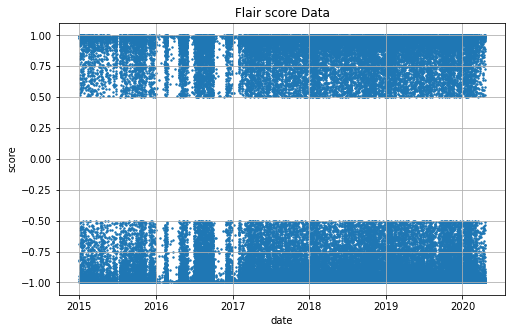

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(df["date"], df["flair_score"], s=2)

# Same as above
ax.set_xlabel('date')
ax.set_ylabel('score')
ax.set_title('Flair score Data')
ax.grid(True)

From what we visually see, there seems to be dates with almost no quotes before 2017. This probably comes from the quotebank dataset itself. We will need to keep that in mind when doing our analysis.

To further see if there is a trend with the compound score, we will compute the average per day.

In [25]:
# Date is currently precise to the second, but we simply want the date
df["date_simp"] = pd.DatetimeIndex(df['date']).normalize() # df["date"].progress_apply(get_day)

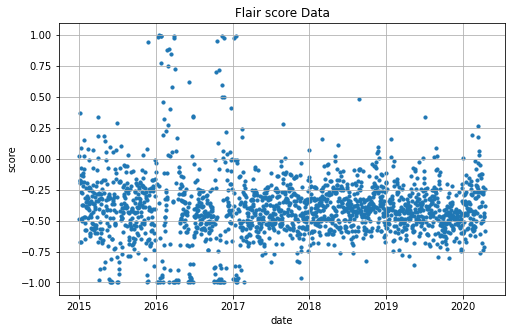

In [26]:
# Plot the average for each day
by_date = df.groupby(["date_simp"])["flair_score"].mean()

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(by_date.index, by_date, s=10)


# Same as above
ax.set_xlabel('date')
ax.set_ylabel('score')
ax.set_title('Flair score Data')
ax.grid(True)

With the aggregated data, we don't seem to see a trend (maybe a downward trend?). We do see, however, that the variance seem to be higher before 2017. Again, it is clear that this effect comes, in part, from the fact that some days seem to be missing.

We will now further analyze the dataset by exploring different things per party.

In [27]:
df.keys()

Index(['Unnamed: 0', 'quoteID', 'quotation', 'speaker', 'qids', 'date',
       'numOccurrences', 'probas', 'urls', 'phase', 'subset', 'id',
       'givenName', 'familyName', 'unaccentedGivenName',
       'unaccentedFamilyName', 'birthYear', 'deathYear', 'congresses',
       'middleName', 'unaccentedMiddleName', 'nickName', 'honorificPrefix',
       'honorificSuffix', 'position', 'stateName', 'parties', 'NLTK score',
       'neg', 'neu', 'pos', 'compound', 'textblob_score', 'flair_score',
       'date_simp'],
      dtype='object')

### b. Analysis

In [86]:
# Split the df by party
party_grps = df.groupby('parties')
df_rep = df[df["parties"] == "Republican"]
df_dem = df[df["parties"] == "Democrat"]

In [87]:
for party, grp in party_grps:
    print(f'Number of {party} quotes: {len(grp)}')

Number of Democrat quotes: 49672
Number of Republican quotes: 56257


#### Quotes sentiment for each party (using NLTK)

The following distributions show the amount of quotes categorized in each sentiment categories (neutral, negative, positive). The axis represent the amount of certainty a quote is to be categorized as such. Therefore, quotes on the left side of the graph are uncertainly classified as its type while quotes on the right are highly likely to be classified in the right type, according to our sentiment analysis classifier. <br>

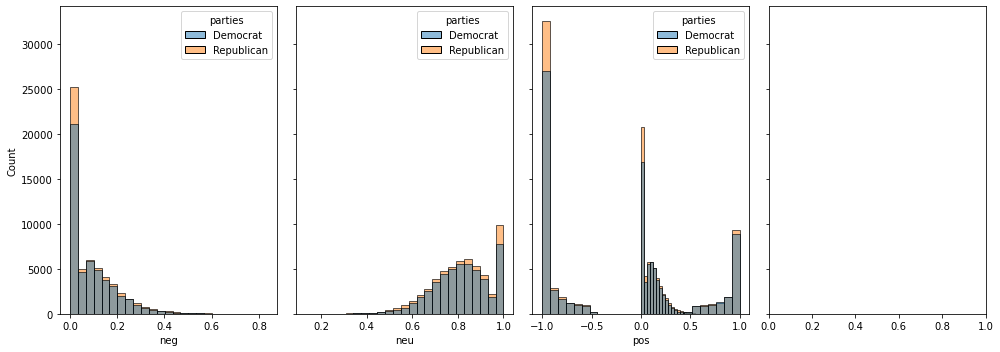

In [88]:
fig, axes = plt.subplots(1, 4, figsize=(14,5), sharey=True)
sns.histplot(data=df, x='neg', hue='parties', ax=axes[0], bins=25)
sns.histplot(data=df, x='neu', hue='parties', ax=axes[1], bins=25)
sns.histplot(data=df, x='pos', hue='parties', ax=axes[2], bins=25)
sns.histplot(data=df, x='flair', hue='parties', ax=axes[2], bins=25)
fig.tight_layout()

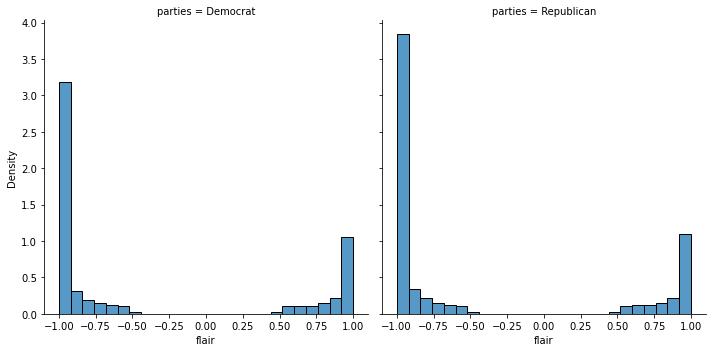

In [89]:
sns.displot(data=df, x='flair', stat='density', col='parties', bins=25, kind='hist', col_wrap=2)


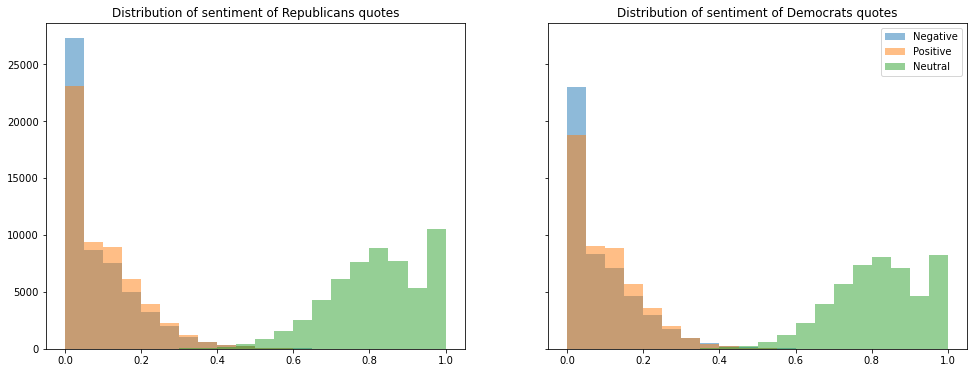

In [90]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(16.5,6))
# Overall distribution of republicans quotes sentiment
labels = ['neg','pos', 'neu']
axes[0].hist(df_rep['neg'], alpha=0.5, bins=np.arange(0, 1+1e-10, 0.05))
axes[0].hist(df_rep['pos'], alpha=0.5, bins=np.arange(0, 1+1e-10, 0.05))
axes[0].hist(df_rep['neu'], alpha=0.5, bins=np.arange(0, 1+1e-10, 0.05))
axes[0].set_title('Distribution of sentiment of Republicans quotes')
axes[1].hist(df_dem['neg'], alpha=0.5, bins=np.arange(0, 1+1e-10, 0.05))
axes[1].hist(df_dem['pos'], alpha=0.5, bins=np.arange(0, 1+1e-10, 0.05))
axes[1].hist(df_dem['neu'], alpha=0.5, bins=np.arange(0, 1+1e-10, 0.05))
labels = ['Negative','Positive', 'Neutral']
axes[1].set_title('Distribution of sentiment of Democrats quotes')
plt.legend(labels)

In [91]:
for name, value in zip(['Compound', 'Negative', 'Neutral', 'Positive'], ['compound', 'neg', 'neu', 'pos']):
    print(name)
    display(party_grps[value].describe())
    print(scipy.stats.ttest_ind(party_grps.get_group('Democrat')[value], party_grps.get_group('Republican')[value]))
    print('')

Compound


,count,mean,std,min,25%,50%,75%,max
parties,,,,,,,,
Democrat,49672.0,0.049648,0.518496,-0.9958,-0.3612,0.0,0.4767,0.9990
Republican,56257.0,0.044364,0.513539,-0.9965,-0.3612,0.0,0.4522,0.9989


Ttest_indResult(statistic=1.6638992520114593, pvalue=0.09613552248150549)

Negative


,count,mean,std,min,25%,50%,75%,max
parties,,,,,,,,
Democrat,49672.0,0.085746,0.099209,0.0,0.0,0.061,0.14025,0.737
Republican,56257.0,0.085280,0.104146,0.0,0.0,0.055,0.14000,0.835


Ttest_indResult(statistic=0.7428796097784959, pvalue=0.4575562190165472)

Neutral


,count,mean,std,min,25%,50%,75%,max
parties,,,,,,,,
Democrat,49672.0,0.816635,0.123868,0.133,0.735,0.820,0.904,1.0
Republican,56257.0,0.818099,0.130460,0.165,0.734,0.824,0.913,1.0


Ttest_indResult(statistic=-1.8662805000581908, pvalue=0.06200489271517315)

Positive


,count,mean,std,min,25%,50%,75%,max
parties,,,,,,,,
Democrat,49672.0,0.097616,0.097041,0.0,0.0,0.085,0.155,0.756
Republican,56257.0,0.096620,0.102940,0.0,0.0,0.077,0.156,0.737


Ttest_indResult(statistic=1.6139935028982755, pvalue=0.10653181416833096)



Not all quotes that where pos > neg have a positive compound nor is the opposite true

In [92]:
df = df.assign(
    pos_sentiment=lambda x: x.neg <= x.pos, 
    days_since_start=lambda x: (x.date_simp - df.date_simp.min()).dt.total_seconds()/(24*60*60)
)
df = df.assign(compound_check= lambda x: x.pos_sentiment == (x.compound >= 0))
display(df[df['compound_check'] == False].sample(5))
df['compound_check'].value_counts()

,Unnamed: 0,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,...,NLTK score,neg,neu,pos,compound,flair,date_simp,pos_sentiment,days_since_start,compound_check
36166,685073,2017-05-02-138461,we want to make sure that every american has a...,yvette clarke,['Q461679'],2017-05-02 21:36:24,2.0,"[['Yvette Clarke', '0.838'], ['None', '0.1308'...",['http://rss.cnn.com/~r/rss/cnn_allpolitics/~3...,E,...,"{'neg': 0.068, 'neu': 0.835, 'pos': 0.097, 'co...",0.068,0.835,0.097,-0.1280,-0.864498,2017-05-02,True,852.0,False
75237,267171,2019-10-12-018810,i strongly condemn both president erdoğan's de...,eliot engel,['Q1329618'],2019-10-12 02:07:35,1.0,"[['Eliot Engel', '0.7407'], ['None', '0.2545']...",['https://hypervocal.com/items/2990734'],E,...,"{'neg': 0.108, 'neu': 0.764, 'pos': 0.128, 'co...",0.108,0.764,0.128,-0.0772,-0.997296,2019-10-12,True,1745.0,False
76044,318330,2019-04-02-063721,less than half of that has been authorized and...,kirsten gillibrand,['Q22222'],2019-04-02 14:20:07,1.0,"[['Kirsten Gillibrand', '0.4361'], ['None', '0...",['http://www.newsmax.com/newsfront/gillibrand-...,E,...,"{'neg': 0.091, 'neu': 0.829, 'pos': 0.079, 'co...",0.091,0.829,0.079,0.2846,-0.999984,2019-04-02,False,1552.0,False
41359,247354,2017-10-04-155360,we are not going to knee-jerk react to every s...,chris collins,"['Q1077119', 'Q21284804', 'Q26935189', 'Q27831...",2017-10-04 17:28:57,2.0,"[['Chris Collins', '0.7689'], ['None', '0.1931...",['http://feeds.nydailynews.com/~r/nydnrss/spor...,E,...,"{'neg': 0.053, 'neu': 0.884, 'pos': 0.063, 'co...",0.053,0.884,0.063,-0.1311,-0.975382,2017-10-04,True,1007.0,False
11268,114143,2016-09-06-126837,we've never had the nominee of one of our majo...,hillary clinton,['Q6294'],2016-09-06 07:54:49,2.0,"[['Hillary Clinton', '0.6145'], ['None', '0.35...",['http://theweek.com/speedreads/647003/bill-cl...,E,...,"{'neg': 0.096, 'neu': 0.791, 'pos': 0.113, 'co...",0.096,0.791,0.113,-0.1027,-0.995301,2016-09-06,True,614.0,False


True     104302
False      1627
Name: compound_check, dtype: int64

We can see that there are a lot of quotes classified as having a certainly neutral tone while the ones with a positive or negative tone are of small certainty. <br>
There seems to be overall a bit more negatively assigned quotes rather than positively, and that republicans have overall been more often critics of the opponent party than the democrats.

Next, we'll look at the compound sentiment value for each party accross each year of interest.

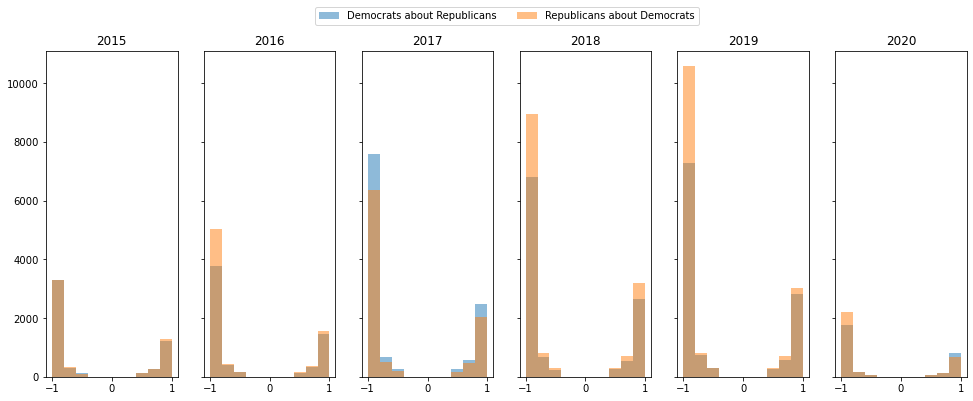

In [93]:
year = 2015
fig, axes = plt.subplots(1, 6, sharey=True, figsize=(16.5,6))
for i in range(0,6):
    axes[i].hist(df_dem[df_dem['date'].astype(str).str.contains(f"{year}")]['flair'], alpha = 0.5, label ="Democrats about Republicans");
    axes[i].hist(df_rep[df_rep['date'].astype(str).str.contains(f"{year}")]['flair'], alpha=0.5, label ="Republicans about Democrats");
    axes[i].set_title(f"{year}");
    year = year + 1
axes[0].legend(bbox_to_anchor =(5, 1.15), ncol = 2)

The various distributions of quotes sentiment scores over each year show us 2 things. <br>
First, except for the year 2020 (for which we lack data), there have been more and more quotes coming from either party mentionning the opposition one. <br>
Second, that depending on the year we see different amount of quote mentionning the other party. Indeed, in 2015 the distributions look pretty similar in shape (with the increase); from 2016 to 2019, we've extracted more quotes about republicans mentionning democrats rather than the opposite, except in 2017 where democrats seem to have been more actively speaking about their opponent. This can be explained by the presidential election that occurred in the beggining of this year and the following criticism the newly president may have faced (especially with his controversial ideas about Muslim-majority nations travel ban, Mexico wall..). <br>
We'll later dive deeper in this direction and check the consequence on these distributions of specific events.

#### Most common words analysis

Here we take a look at the words the most used by each party. 

In [52]:
#remove and keep some of the stopwords
from nltk.corpus import stopwords
stop = stopwords.words("english")

# Add to the stopword list common words an punctuation that is present for both emotions
stop = stop + ["going", "would", "want", "get", "one", "-", "_", "[", "]"]


df_rep = df_rep.assign(qoutation_clean=df_rep["quotation"].apply(lambda x: " ".join(x for x in x.split() if x not in stop)))
df_dem = df_dem.assign(qoutation_clean=df_dem["quotation"].apply(lambda x: " ".join(x for x in x.split() if x not in stop)))

These histograms show those most common words after a first sorting where we've removed common english stopwords (mostly determinants, common verbs and punctuation). These words mostly refers to the opponent party title or its leading member. A further investigation by focusing on certain periods or removing even more general terms could reveal more intense words or speach patterns.

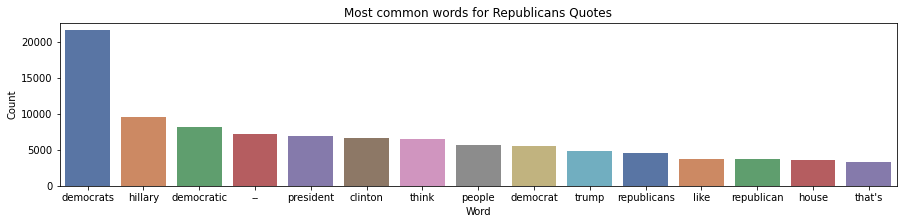

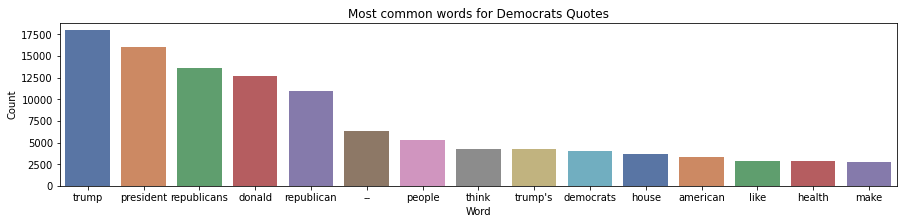

In [53]:
counter(df_rep, 'quotation_clean', 15, 'Republicans Quotes')
counter(df_dem, 'quotation_clean', 15, 'Democrats Quotes')

## Regression

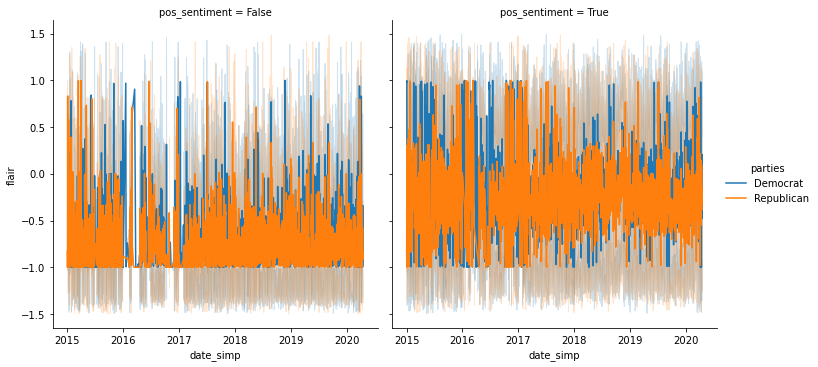

In [94]:
sns.relplot(data=df, x='date_simp', y='flair', hue='parties', kind='line', ci='sd', col='pos_sentiment')

In [95]:
grps = df.groupby(['pos_sentiment', 'parties'])
results = {}
for label, grp in grps:
    res = smf.ols('flair ~ days_since_start', 
        data=grp).fit()
    results[label] = res

ValueError: endog has evaluated to an array with multiple columns that has shape (18709, 17126). This occurs when the variable converted to endog is non-numeric (e.g., bool or str).

In [ ]:
for label, res in results.items():
    print(label)
    print(res.summary())